#  과제1. 수어 번역기 파이프라인

* 데이터 출처 : https://www.kaggle.com/datasets/datamunge/sign-language-mnist?select=sign_mnist_train

## 1.환경준비

### (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import cv2
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

np.set_printoptions(linewidth=np.inf)

In [2]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

In [5]:
# path = 'C:/Users/User/MLOps/data/'
path = "C:/Users/phoneticsbug/MLOps/data/"
file = 'sign_language.csv'

data = pd.read_csv(path+file)
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,22,186,186,185,185,185,184,185,184,184,...,171,122,65,62,215,180,99,47,31,25
1,24,175,177,179,181,181,182,182,182,183,...,202,202,201,200,199,197,195,193,191,189
2,6,187,187,187,187,187,186,187,186,186,...,45,23,25,34,41,43,39,40,43,35
3,2,169,169,169,170,169,170,169,169,169,...,204,203,200,199,198,196,194,193,191,190
4,21,153,165,170,179,190,198,203,206,213,...,161,122,132,96,75,63,37,43,70,66


In [6]:
data.shape

(8000, 785)

### (3) class names
* label이 0 ~ 27 까지의 숫자로 표현됩니다.
* 수어 중에서 J(9) 와 Z(27)는 손을 움직이면서 표현해야 하므로, 여기서는 제외합니다.
* 숫자로 레이블링 된 것을, 나중에 문자 변환하기 위해 문자로 된 리스트를 생성합니다.

In [7]:
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)
len(class_names), class_names

(26,
 array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1'))

## 2 데이터 살펴보기

### (1) 데이터 한 건을 2차원으로 변환하고 그림 그리기

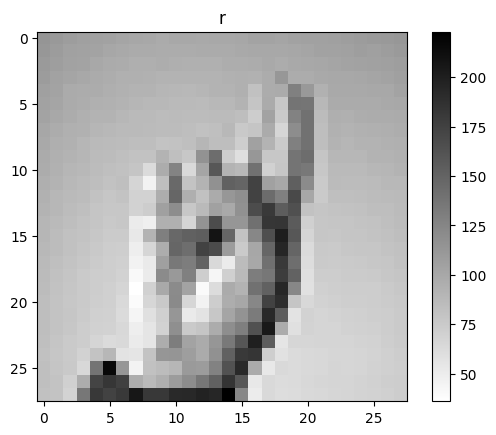

In [8]:
# 아래 숫자를 바꿔가며 화면에 그려 봅시다.
n = 100
sign_fig = data.iloc[n, 1:].values
sign_fig = sign_fig.reshape(28, 28)

sign = class_names[data.iloc[n,0]]

plt.title(sign)
plt.imshow(255-sign_fig, cmap=plt.cm.binary)
plt.colorbar()
plt.show()

## 3.데이터 준비

* 주어진 데이터셋
    * 2차원 데이터셋, 1차원 데이터포인트(분석단위, 예측단위) 입니다. 
    * 흑백 이미지데이터
    * 이 데이터로부터 데이터 준비작업을 수행합니다.
        * 데이터 분할1 : x, y
        * 데이터 분할2 : train, validation
        * 만약 CNN으로 모델링을 한다면, shape를 맞춰야 합니다. (n, 28, 28, 1) 
        * scaling
* 그러나 운영에서 발생될 데이터는 이미지 한장 한장 입니다. 이미지 한장, 한장 들어온다면 어떻게 데이터가 처리되어야 할까요?(Data Pipeline 구성)

### (1) 데이터 분할1 : x, y 나누기

In [9]:
target = 'label'
x = data.drop(target, axis=1)
y = data[target]

In [10]:
len(set(y.values)), len(set(data['label'].values))

(24, 24)

In [22]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y)
y.shape

(8000, 25)

### (2) 데이터 분할2 : train, validation

* train : val : test = 5000 : 2000 : 1000
* 여기서 test set은 파이프라인 점검을 위한 용도로 사용합니다.

In [23]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size= 2000, random_state = 20)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=1000, random_state=20)
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((5000, 784), (2000, 784), (1000, 784), (5000, 25), (2000, 25), (1000, 25))

In [24]:
# 모두 넘파이로 변환
x_train, x_val, x_test, y_train, y_val, y_test = np.array(x_train), np.array(x_val), np.array(x_test), np.array(y_train), np.array(y_val), np.array(y_test)
type(x_train), x_train.shape

(numpy.ndarray, (5000, 784))

### (3) shape 맞추기 n, 28,28,1

* reshape
    * x_train.shape : (-1, 28, 28, 1)
    * x_val.shape : (-1, 28, 28, 1)

In [25]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_val = np.reshape(x_val, (len(x_val), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [26]:
x_train.shape, x_val.shape, x_test.shape

((5000, 28, 28, 1), (2000, 28, 28, 1), (1000, 28, 28, 1))

### (4) Scaling : Min-Max

* 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
* x_train, x_test를 그냥 255로 나누면 됨

In [27]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()

x_train_m =x_train/255
x_val_m = x_val/255
x_test_m = x_test/255

x_train_m.shape, x_val_m.shape, x_test_m.shape

((5000, 28, 28, 1), (2000, 28, 28, 1), (1000, 28, 28, 1))

In [28]:
print(x_train_m[0])

[[[0.65098039]
  [0.65490196]
  [0.65490196]
  [0.6627451 ]
  [0.66666667]
  [0.67058824]
  [0.67058824]
  [0.6745098 ]
  [0.67843137]
  [0.67843137]
  [0.68235294]
  [0.68235294]
  [0.6745098 ]
  [0.67843137]
  [0.69411765]
  [0.69411765]
  [0.68235294]
  [0.68235294]
  [0.68235294]
  [0.67843137]
  [0.6745098 ]
  [0.67058824]
  [0.6627451 ]
  [0.65490196]
  [0.65882353]
  [0.65490196]
  [0.64705882]
  [0.63921569]]

 [[0.6627451 ]
  [0.66666667]
  [0.67058824]
  [0.67843137]
  [0.68235294]
  [0.68627451]
  [0.68627451]
  [0.68627451]
  [0.69411765]
  [0.69803922]
  [0.69803922]
  [0.70980392]
  [0.69803922]
  [0.70980392]
  [0.62352941]
  [0.64705882]
  [0.70588235]
  [0.69411765]
  [0.69803922]
  [0.69019608]
  [0.68627451]
  [0.68235294]
  [0.67843137]
  [0.67058824]
  [0.66666667]
  [0.6627451 ]
  [0.65882353]
  [0.65882353]]

 [[0.68235294]
  [0.68627451]
  [0.69019608]
  [0.69411765]
  [0.70196078]
  [0.70588235]
  [0.70588235]
  [0.70588235]
  [0.71372549]
  [0.71764706]
  [0.7

(5) to_categorical 적용하기

In [29]:
y_train.shape, y_val.shape, y_test.shape

((5000, 25), (2000, 25), (1000, 25))

In [69]:
len(y_train[0])

TypeError: object of type 'numpy.int64' has no len()

In [17]:
from tensorflow.keras.utils import to_categorical

## 4.모델링

### (1) 모델 설계

In [37]:
from tensorflow import keras
from tensorflow.keras import layers

# 모델 구축
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(25, activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 모델 요약
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 5408)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                346176    
                                                                 
 dense_9 (Dense)             (None, 25)                1625      
                                                                 
Total params: 348,121
Trainable params: 348,121
Non-trainable params: 0
________________________________________________

### (2) 학습

In [38]:
history = model.fit(x_train_m, y_train, batch_size=64, epochs=100, validation_data = (x_val_m, y_val))

# 학습 과정에서 발생한 손실과 정확도 기록
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

Epoch 1/100
79/79 [==============================] - 3s 23ms/step - loss: 3.0601 - accuracy: 0.1368 - val_loss: 2.7233 - val_accuracy: 0.3110
Epoch 2/100
79/79 [==============================] - 2s 20ms/step - loss: 2.1987 - accuracy: 0.4268 - val_loss: 1.7013 - val_accuracy: 0.5460
Epoch 3/100
79/79 [==============================] - 2s 19ms/step - loss: 1.4334 - accuracy: 0.6094 - val_loss: 1.2669 - val_accuracy: 0.6350
Epoch 4/100
79/79 [==============================] - 2s 20ms/step - loss: 1.0456 - accuracy: 0.7184 - val_loss: 0.9572 - val_accuracy: 0.7325
Epoch 5/100
79/79 [==============================] - 2s 23ms/step - loss: 0.8022 - accuracy: 0.7840 - val_loss: 0.7623 - val_accuracy: 0.7885
Epoch 6/100
79/79 [==============================] - 2s 22ms/step - loss: 0.6539 - accuracy: 0.8314 - val_loss: 0.6162 - val_accuracy: 0.8280
Epoch 7/100
79/79 [==============================] - 2s 20ms/step - loss: 0.5227 - accuracy: 0.8676 - val_loss: 0.5741 - val_accuracy: 0.8350
Epoch 

### (3) 학습결과 그래프

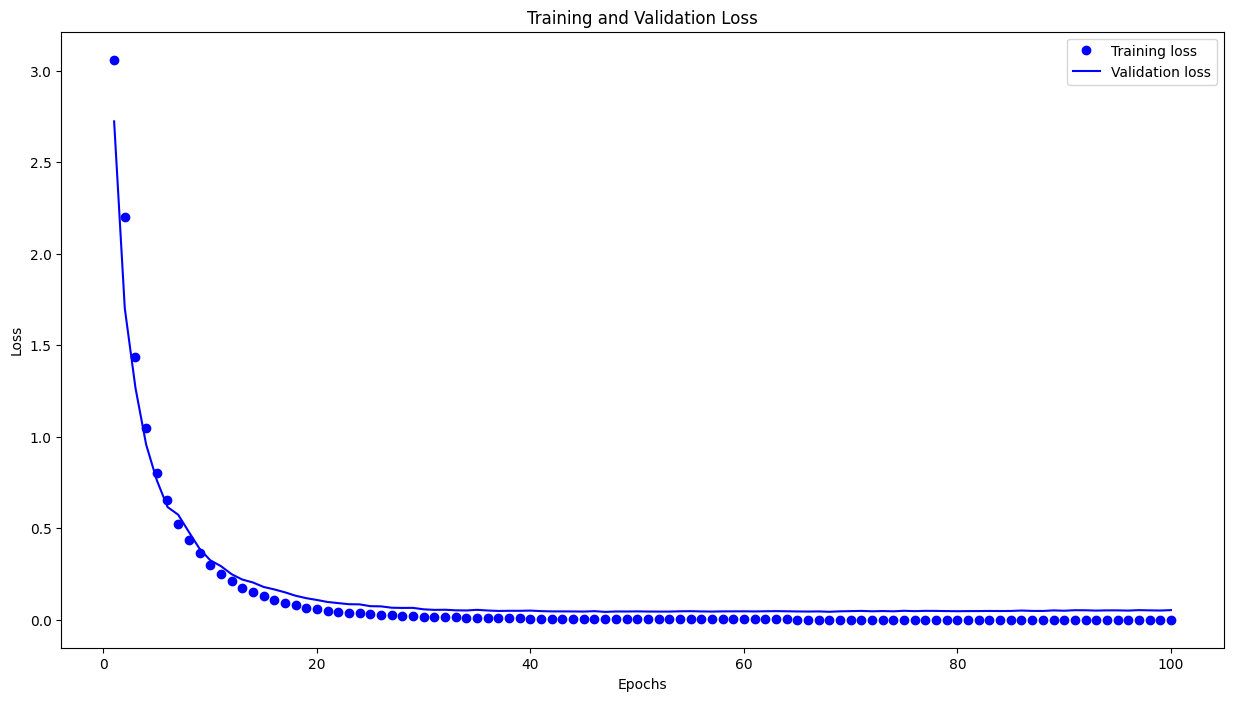

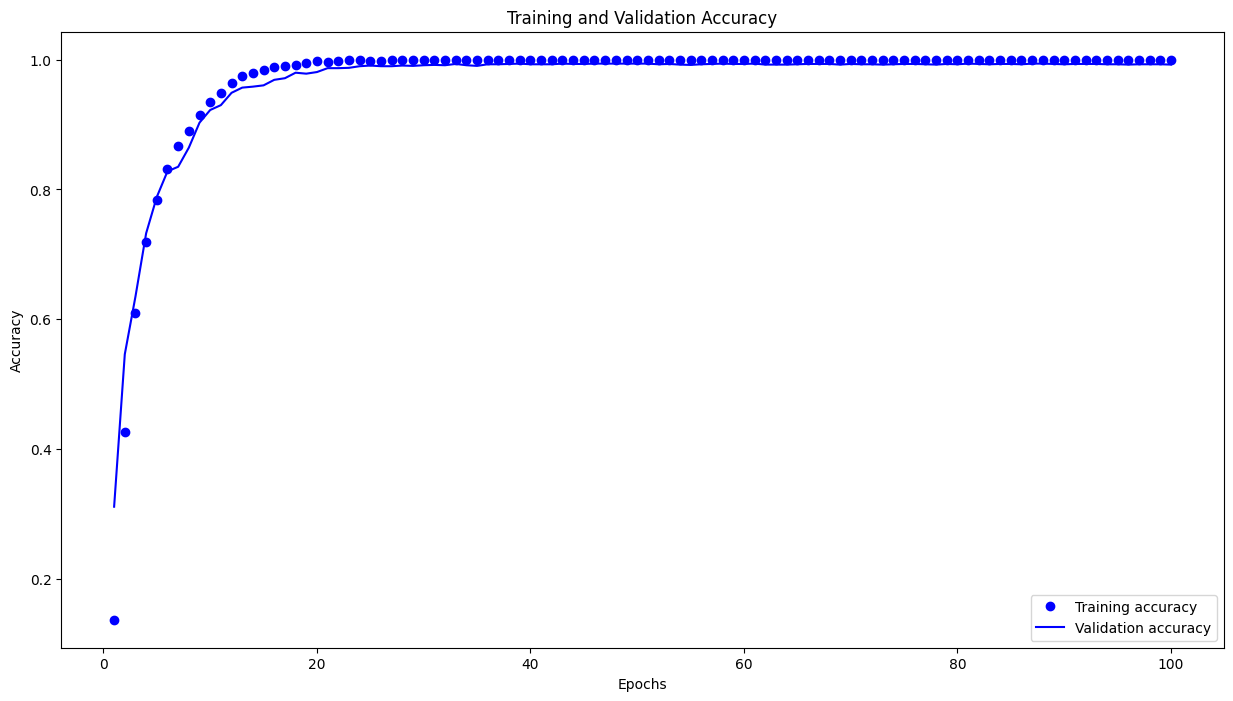

In [41]:

epochs = range(1, len(train_loss) + 1)

# 손실 그래프
plt.figure(figsize=(15, 8))
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 정확도 그래프
plt.figure(figsize=(15, 8))
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### (4) 예측 및 검증

In [46]:
y_pred = model.predict(x_test_m)

32/32 [==============================] - 0s 3ms/step


In [63]:
from itertools import combinations
N = int(input())
letters = [input() for _ in range(N)]
for i in combinations(letters, 3):
    print(i)

('ab', 'ba', 'c')


In [ ]:
0 1 1 1
1 0 1 1
1 1 0 1
1 1 1 0

## 5.저장하기

* 여기서는 joblib을 이용하여 모델과 데이터셋을 저장하겠습니다.

### (1) 모델 저장하기

### (2) 모델 로딩하기
* 로딩시 model2로 저장합니다.

In [ ]:
model2 = 

### (3) test 셋으로 예측하고 평가해보기

* test 셋에 필요한 전처리는 다음과 같습니다.
    * 넘파이 어레이로 변환
    * 4차원 데이터셋으로 변환
    * 스케일링

In [ ]:
# 넘파이 어레이로 변환


# 4차원 데이터셋


# 스케일링


In [ ]:
# 예측하고 평가하기



## 6.Data Pipeline 구성

### (1) 라이브러리 로딩

In [ ]:
# 파이프라인에서 필요한 라이브러리/함수
import pandas as pd
import numpy as np
import cv2
import joblib

### (2) 테스트 데이터 로딩
* 제공받은 이미지로 테스트 해보기
* 직접 찍은 사진으로 테스트 해보기

In [9]:
# 파일 열기
path = 'test image/'
file = 'v.png'
filename = path + file

img = cv2.imread(filename)
cv2.imshow('img', img)

cv2.waitKey(0) # 키보드 입력 대기
cv2.destroyAllWindows() # 키보드 입력이 있으면 이미지 창 닫기

### (3) Data Pipeline에 포함되어야 할 절차
* 이미지 크기 맞추기
* 흑백이미지
* 스케일링

#### 1)이미지 읽을 때 흑백으로 읽기

In [ ]:
# 파일 열기
img = cv2.imread(filename , cv2.IMREAD_GRAYSCALE)

# 조회는 파이프라인 불필요
print(img.shape)
cv2.imshow('img', img)
cv2.waitKey(0) # 키보드 입력 대기
cv2.destroyAllWindows() # 키보드 입력이 있으면 이미지 창 닫기

#### 2)이미지 크기를 28, 28, 1 로 맞추기
* 이미지 크기를 조절하는 방법은 크게 두가지 입니다.
    * numpy 
    * opencv의 resize 함수 이용

In [ ]:
# 크기 조절하기
img = cv2.resize(img, (28, 28))

# 조회는 파이프라인 불필요
print(img.shape)
cv2.imshow('img', img)
cv2.waitKey(0) # 키보드 입력 대기
cv2.destroyAllWindows() # 키보드 입력이 있으면 이미지 창 닫기

In [ ]:
# 입력데이터 형식을 갖추기 : (1,28,28,1)


#### 3)스케일링

#### 4)모델 로딩하기

#### 5)예측하기

### (4) 하나의 셀로 합치기

* 코드를 하나로 모으기

In [ ]:
# 파이프라인에서 필요한 라이브러리/함수
import pandas as pd
import numpy as np
import cv2
import joblib

# class names 준비


# 파일 로딩


# 흑백으로 읽기


# 크기 조정


# input shape 맞추기


# 스케일링


# 모델 로딩


# 예측

